In [211]:
!pip install tonic
!pip install snntorch



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [212]:
import tonic
import tonic.transforms as transforms
import torch
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
import torchvision
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
dtype = torch.float
sensor_size=tonic.datasets.NMNIST.sensor_size
frame_transform= transforms.Compose([transforms.Denoise(filter_time=10000), transforms.ToFrame(sensor_size=sensor_size, time_window=10000)])
trainset= tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset= tonic.datasets. NMNIST(save_to='./data', transform=frame_transform, train=False)  
transform= tonic.transforms.Compose([torch.from_numpy, torchvision.transforms.RandomRotation([-10, 10])])
cached_trainset= DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')
cached_testset= DiskCachedDataset(testset, cache_path='./cache/nmnist/test') 
batch_size=128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
spike_grad = surrogate.atan()
beta = 0.5
num_steps = 30
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)
def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)
  for step in range(data.size(0)):
    spk_out, mem_out = net(data[step])
    spk_rec.append(spk_out)
  return torch.stack(spk_rec) 


In [213]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
temporal_loss = nn.MSELoss()

In [ ]:
num_epochs = 1
num_iters = 100

loss_hist = []
acc_hist = []
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)
        net.train()
        spk_rec = forward_pass(net, data)
        #loss_val = loss_fn(spk_rec, targets)
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        temp_loss= torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            target_zeros = torch.zeros_like(spk_rec)
            temporal_threshold = 7
            if step < temporal_threshold:
                 target_zeros = torch.zeros_like(spk_rec[step])
                 loss_val += temporal_loss(spk_rec[step], target_zeros)*40
                 temp_loss += temporal_loss(spk_rec[step], target_zeros)*40
            loss_val+= loss_fn(spk_rec, targets)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        loss_hist.append(loss_val.item())
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")
        print(f"Temporal Loss (first {temporal_threshold} steps): {temp_loss.item():.2f}")
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")
        # training loop breaks after 50 iterations
        if i == num_iters:
          break



Epoch 0, Iteration 0 
Train Loss: 87.10
Temporal Loss (first 5 steps): 0.00
Accuracy: 9.38%

Epoch 0, Iteration 1 
Train Loss: 84.31
Temporal Loss (first 5 steps): 45.28
Accuracy: 12.50%

Epoch 0, Iteration 2 
Train Loss: 86.87
Temporal Loss (first 5 steps): 0.00
Accuracy: 14.06%

Epoch 0, Iteration 3 
Train Loss: 86.81
Temporal Loss (first 5 steps): 0.00
Accuracy: 7.81%

Epoch 0, Iteration 4 
Train Loss: 86.79
Temporal Loss (first 5 steps): 0.00
Accuracy: 9.38%

Epoch 0, Iteration 5 
Train Loss: 83.41
Temporal Loss (first 5 steps): 0.03
Accuracy: 13.28%

Epoch 0, Iteration 6 
Train Loss: 67.57
Temporal Loss (first 5 steps): 1.06
Accuracy: 6.25%

Epoch 0, Iteration 7 
Train Loss: 66.98
Temporal Loss (first 5 steps): 25.09
Accuracy: 10.94%

Epoch 0, Iteration 8 
Train Loss: 79.09
Temporal Loss (first 5 steps): 34.31
Accuracy: 9.38%

Epoch 0, Iteration 9 
Train Loss: 58.49
Temporal Loss (first 5 steps): 20.72
Accuracy: 5.47%

Epoch 0, Iteration 10 
Train Loss: 44.36
Temporal Loss (first 

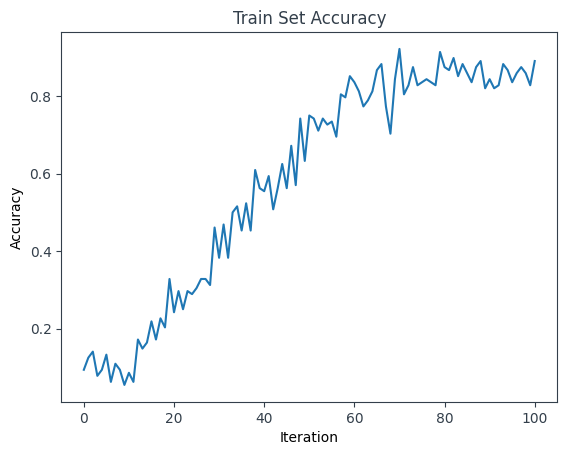

In [215]:


# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()